# 2 ReactomeSuperPathwaysDrivers - Topological Features and Layouts

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import glob
import numpy as np
import pickle 
import statistics as st

In [2]:
class SuperPathwayClass:
    def __init__(self, name,idPathway,geneSet,networkWithCCs,networkLCC,drivers):
        self.name = name
        self.idPathway = idPathway
        self.geneSet = geneSet
        self.networkCCs = networkWithCCs
        self.networkLCC = networkLCC
        self.drivers = drivers
        self.topologicalFeaturesLCC = None
        self.layout_LCC_kamada_kawai= None
        self.layout_CCs_spring = None
        
    def info(self):
        info={}
        info['Name'] = self.name
        info['idPathway'] = self.idPathway        
        info['lenSet'] = len(self.geneSet)
        info['lenCCs'] = str(len(self.networkCCs.nodes)) +' ('+str(round(len(self.networkCCs.nodes)/len(self.geneSet)*100))+'%)'
        info['lenLCC'] = str(len(self.networkLCC.nodes)) +' ('+str(round(len(self.networkLCC.nodes)/len(self.geneSet)*100))+'%)'       
        driversLen = len(self.drivers)
        info['driversLCC'] = driversLen
        info['drivers %'] = round(driversLen/len(self.networkLCC.nodes)*100)
        
        return info

### Topological Functions

In [3]:
def leverageCentrality(G):
    nodes = list(G.nodes)
    degrees = G.degree
    leverageCentrality ={}
    for node in nodes:
        if(len(list(G.neighbors(node)))==0):
            leverageCentrality[node] = 0
        else:
            leverage=0
            for n in G.neighbors(node):
                leverage += (degrees[node]-degrees[n]) / (degrees[node]+degrees[n])
            leverageCentrality[node] = round(((1/degrees[node]) * leverage),4)
    return leverageCentrality

def averageNeighborDegree(G):
    nodes = list(G.nodes)
    degrees = G.degree
    avgDegree = st.mean([t[1] for t in degrees])
    averageNeighborDegree ={}
    for node in nodes:
        neighborsDegree=0
        if(len(list(G.neighbors(node)))==0):
            averageNeighborDegree[node] = 0
        else:
            for n in G.neighbors(node):
                neighborsDegree += degrees[n]
            averageNeighborDegree[node] = neighborsDegree/len(list(G.neighbors(node)))
    return averageNeighborDegree

def bridgingCentrality(G):
    nodes = list(G.nodes)
    degrees = G.degree
    #betweenness
    bet = nx.betweenness_centrality(G)
    #bridging centrality
    bridging_centrality={}
    for node in nodes:
        if(degrees[node]!=0):
            nodeDegreeInverse = degrees[node]**-1
            neighborsDegreeInverse=0
            for n in G.neighbors(node):
                neighborsDegreeInverse += degrees[n]**-1                
            #In Digraphs, neighborsDegreeInverse can be 0
            if(neighborsDegreeInverse==0):
                bridging_centrality[node] = 0
            else:
                bridging_centrality[node] = (nodeDegreeInverse/neighborsDegreeInverse) * bet[node]
        else:
            bridging_centrality[node] = 0
    return bridging_centrality

In [4]:
def get_df_eccentricity_centrality(network):
    #If the network has more than one connected component, it falls into an infinite loop. 
    #So the eccentricity is calculated by every CC
    CCsubGraph = [network.subgraph(c).copy() for c in nx.connected_components(network)]
    for i, subG in enumerate(CCsubGraph):
        if(i==0):          
            centrality=nx.eccentricity(subG)
            df = pd.DataFrame([centrality]).T
            df.columns=["eccentricity"]
            df.index.name = 'nodeName'
        else:
            centrality=nx.eccentricity(subG)
            df2 = pd.DataFrame([centrality]).T
            df2.columns=["eccentricity"]
            df2.index.name = 'nodeName'            
            df = df.append(df2)  

    return df

def get_df_bridgingCentrality_centrality(network):
    centrality = bridgingCentrality(network)
    df = pd.DataFrame([centrality]).T
    df.columns=["bridging"]
    df.index.name = 'nodeName'
    return df 

def get_df_leverage_centrality(network):
    centrality = leverageCentrality(network)
    df = pd.DataFrame([centrality]).T
    df.columns=["leverage"]
    df.index.name = 'nodeName'
    return df

def get_df_averageNeighbor_centrality(network):
    centrality = averageNeighborDegree(network)
    df = pd.DataFrame([centrality]).T
    df.columns=["averageNeighbor"]
    df.index.name = 'nodeName'
    return df   


def get_df_degree_centrality(network):
    centrality = dict(nx.degree(network))
    degree_df = pd.DataFrame([centrality]).T
    degree_df.columns=["degree"]
    degree_df.index.name = 'nodeName'
    return degree_df

# average distance of a node to all other ones
def get_df_closeness_centrality(network):
    centrality = nx.closeness_centrality(network)
    closeness_df = pd.DataFrame([centrality]).T
    closeness_df.columns=["closeness"]
    closeness_df.index.name = 'nodeName'
    return closeness_df

def get_df_betweenness_centrality(network):
    centrality = nx.betweenness_centrality(network)
    betweenness_df = pd.DataFrame([centrality]).T
    betweenness_df.columns=["betweenness"]
    betweenness_df.index.name = 'nodeName'
    return betweenness_df

def get_df_eigenvector_centrality(network):
    centrality = nx.eigenvector_centrality(network, max_iter = 1000)
    eigenvector_df = pd.DataFrame([centrality]).T
    eigenvector_df.columns=["eigenvector"]
    eigenvector_df.index.name = 'nodeName'
    return eigenvector_df

# k-core is a measure related to network decomposition in subgraphs, such that the resulting sugraph has a miniman degree equals to k    
def get_df_kcore(network):
    kc = nx.core_number(network)
    kc_df = pd.DataFrame([kc]).T
    kc_df.columns=["kcore"]
    kc_df.index.name = 'nodeName'
    return kc_df

# clustering of each node is defined by the fraction of edges among the neighbors of each node
def get_df_clustering_coefficient(network):
    cc = {}
    for nodeName in network.nodes():
        cc[nodeName] = nx.clustering(network, nodeName)
    cc_df = pd.DataFrame([cc]).T
    cc_df.columns=["clusteringcoeff"]
    cc_df.index.name = 'nodeName'
    return cc_df

In [5]:
def centralityMeasures(G):
    df = get_df_degree_centrality(G)
    df = pd.merge(df,get_df_kcore(G), on="nodeName")
    df = pd.merge(df,get_df_eigenvector_centrality(G), on="nodeName")
    df = pd.merge(df,get_df_averageNeighbor_centrality(G), on="nodeName")
    df = pd.merge(df,get_df_leverage_centrality(G), on="nodeName")
    df = pd.merge(df,get_df_clustering_coefficient(G), on="nodeName")
    df = pd.merge(df,get_df_eccentricity_centrality(G), on="nodeName")
    df = pd.merge(df,get_df_betweenness_centrality(G), on="nodeName")
    df = pd.merge(df,get_df_closeness_centrality(G), on="nodeName")
    df = pd.merge(df,get_df_bridgingCentrality_centrality(G), on="nodeName")
    return df

### Tests

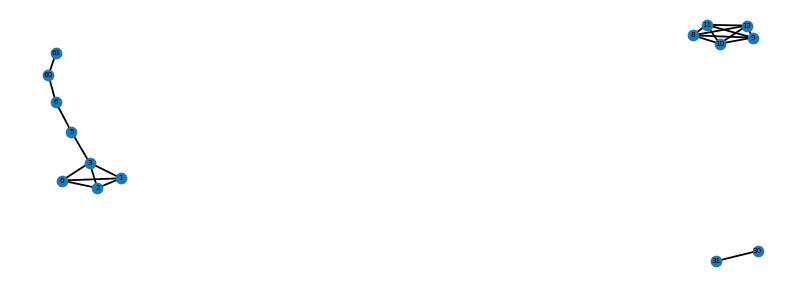

In [6]:
G = nx.barbell_graph(5,3)
G.remove_node(4)
G.remove_node(7)
G.add_edge(5,3)
G.add_edge(6,60)
G.add_edge(60,61)
G.add_edge(30,31)
plt.figure(figsize=(6,2),dpi=130)
nx.draw(G,with_labels=1,node_size=30,font_size=4)
plt.show()

In [7]:
centralityMeasures(G)

,degree,kcore,eigenvector,averageNeighbor,leverage,clusteringcoeff,eccentricity,betweenness,closeness,bridging
nodeName,,,,,,,,,,
0,3,3,1.266702e-05,3.333333,-0.0476,1.0,5,0.000000,0.205882,0.000000
1,3,3,1.266702e-05,3.333333,-0.0476,1.0,5,0.000000,0.205882,0.000000
2,3,3,1.266702e-05,3.333333,-0.0476,1.0,5,0.000000,0.205882,0.000000
3,4,3,1.390900e-05,2.750000,0.1905,0.5,4,0.131868,0.269231,0.021978
5,2,1,5.089686e-06,3.000000,-0.1667,0.0,3,0.131868,0.269231,0.087912
6,2,1,1.859095e-06,2.000000,0.0000,0.0,3,0.109890,0.233333,0.054945
8,4,4,4.472136e-01,4.000000,0.0000,1.0,1,0.000000,0.285714,0.000000
9,4,4,4.472136e-01,4.000000,0.0000,1.0,1,0.000000,0.285714,0.000000
10,4,4,4.472136e-01,4.000000,0.0000,1.0,1,0.000000,0.285714,0.000000


### Open the List of Objects and calculate de topological feature

In [9]:
file = open("1 output/superPathwaysObjs.pkl", "rb")
superPathwaysObjs = pickle.load(file)

In [10]:
%%time
import datetime
for name in ['Digestion and absorption', 'Circadian Clock', 'Reproduction', 'Cell-Cell communication', 'DNA Replication', 'Autophagy', 'Protein localization', 'Muscle contraction', 'Programmed Cell Death', 'Chromatin organization', 'Organelle biogenesis and maintenance', 'Extracellular matrix organization', 'DNA Repair', 'Neuronal System', 'Sensory Perception', 'Cell Cycle', 'Cellular responses to external stimuli', 'Hemostasis', 'Metabolism of RNA', 'Transport of small molecules', 'Vesicle-mediated transport', 'Developmental Biology', 'Gene expression (Transcription)', 'Disease', 'Metabolism of proteins', 'Immune System', 'Metabolism', 'Signal Transduction', 'ReactomeFI_LCC_AllSuperPathways']:
    
    print("\n\nStart: ", datetime.datetime.now())

    print(superPathwaysObjs[name].info())
    CC=superPathwaysObjs[name].networkCCs
    LCC=superPathwaysObjs[name].networkLCC
    
    superPathwaysObjs[name].topologicalFeaturesLCC=centralityMeasures(LCC)
    print("topologicalFeaturesLCC: ", datetime.datetime.now())
    superPathwaysObjs[name].layout_LCC_kamada_kawai=nx.kamada_kawai_layout(LCC)
    print("layout_LCC_kamada_kawai: ", datetime.datetime.now())
    superPathwaysObjs[name].layout_CCs_spring=nx.spring_layout(CC)



Start:  2021-07-06 22:08:19.235056
{'Name': 'Digestion and absorption', 'idPathway': 'R-HSA-8963743', 'lenSet': 28, 'lenCCs': '16 (57%)', 'lenLCC': '3 (11%)', 'driversLCC': 0, 'drivers %': 0}
topologicalFeaturesLCC:  2021-07-06 22:08:19.278095
layout_LCC_kamada_kawai:  2021-07-06 22:08:19.398114


Start:  2021-07-06 22:08:19.398114
{'Name': 'Circadian Clock', 'idPathway': 'R-HSA-400253', 'lenSet': 70, 'lenCCs': '69 (99%)', 'lenLCC': '64 (91%)', 'driversLCC': 12, 'drivers %': 19}
topologicalFeaturesLCC:  2021-07-06 22:08:21.946544
layout_LCC_kamada_kawai:  2021-07-06 22:08:22.546737


Start:  2021-07-06 22:08:22.562343
{'Name': 'Reproduction', 'idPathway': 'R-HSA-1474165', 'lenSet': 114, 'lenCCs': '95 (83%)', 'lenLCC': '81 (71%)', 'driversLCC': 14, 'drivers %': 17}
topologicalFeaturesLCC:  2021-07-06 22:08:24.584597
layout_LCC_kamada_kawai:  2021-07-06 22:08:25.228910


Start:  2021-07-06 22:08:25.260162
{'Name': 'Cell-Cell communication', 'idPathway': 'R-HSA-1500931', 'lenSet': 122, 

#### Save list

In [11]:
file = open("2 output/superPathwaysObjs.pkl", "wb")
pickle.dump(superPathwaysObjs, file)
file.close()

In [13]:
superPathwaysObjs['Transport of small molecules'].topologicalFeaturesLCC

,degree,kcore,eigenvector,averageNeighbor,leverage,clusteringcoeff,eccentricity,betweenness,closeness,bridging
nodeName,,,,,,,,,,
ATP6V1C1,23,21,0.000219,23.304348,-0.0051,0.984190,7,0.000003,0.262456,1.182839e-07
APOA5,10,9,0.000065,17.700000,-0.2345,0.888889,7,0.003734,0.272396,5.758373e-04
PSMB2,54,51,0.134481,56.018519,-0.0036,0.958071,7,0.008276,0.320205,1.194174e-04
ATP1A4,15,11,0.000236,23.000000,-0.0384,0.571429,5,0.001558,0.311667,9.094298e-05
PRKACG,61,22,0.003327,18.934426,0.5597,0.193443,6,0.103877,0.406964,3.030136e-04
...,...,...,...,...,...,...,...,...,...,...
PSMA8,53,51,0.134428,57.037736,-0.0300,0.994920,7,0.000100,0.319658,1.982854e-06
GNG11,17,17,0.000435,36.823529,-0.3424,0.919118,6,0.000061,0.305556,7.210300e-06
CAMK2G,28,11,0.000678,19.642857,0.2386,0.301587,7,0.018106,0.324371,3.114066e-04
